In [35]:
import datetime
import numpy as np
import pandas_datareader as pdr
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

## Data Preparation

In [2]:
# Read the data
end_date = datetime.date.today()
start_date = end_date - relativedelta(years=10)
xchg_rate = pdr.get_data_fred('DEXCAUS', start=start_date, end=end_date)
oil_price = pdr.get_data_fred('DCOILWTICO', start=start_date, end=end_date)

In [3]:
# Remove NA values
oil_price = oil_price.fillna(method='bfill')
xchg_rate = xchg_rate.fillna(method='bfill')

In [4]:
# Calculate the USDCAD exchange rate
xchg_rate['DEXUSCA'] = 1/xchg_rate['DEXCAUS']

In [5]:
# Join the two time series
combined = oil_price.join(xchg_rate, how='inner')

In [6]:
# Calculate percentage change of oil prices & exchange rate
combined['DCOILWTICO_pct_change'] = combined.DCOILWTICO.pct_change()
combined['DEXUSCA_pct_change'] = combined.DEXUSCA.pct_change()

In [7]:
# Drop NaN values in pct_change columns
combined = combined.dropna()

## Visualization

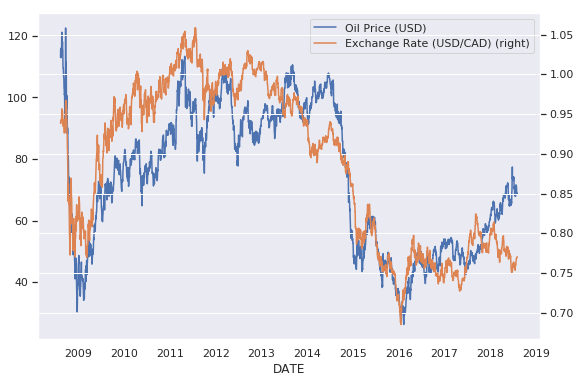

In [8]:
# Plot the levels of oil prices & exchange rate
plt.figure(figsize=(9, 6))
combined.DCOILWTICO.plot(label='Oil Price (USD)', legend=True)
combined.DEXUSCA.plot(label='Exchange Rate (USD/CAD)', secondary_y=True, legend=True)
plt.show()

The USD/CAD exchange rate follows very closely the curve of the oil price (highly dependant)

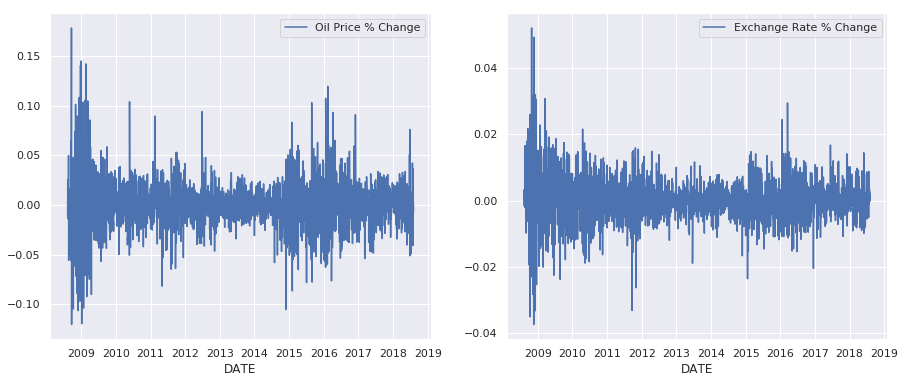

In [9]:
# Plot the percentage change of oil prices & exchange rate
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
combined.DCOILWTICO_pct_change.plot(label='Oil Price % Change', legend=True, ax=ax[0])
combined.DEXUSCA_pct_change.plot(label='Exchange Rate % Change', legend=True, ax=ax[1])
plt.show()

Calculating percentage changes is better for calculating the correlation between the two series and helps visualize their relationship

## Correlation

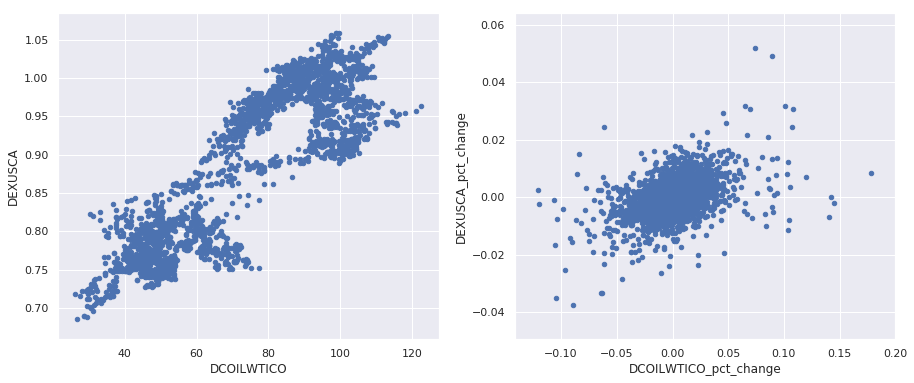

In [10]:
# Scatter plot of oil price vs exchange rate
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
combined.plot(kind='scatter', x='DCOILWTICO', y='DEXUSCA', ax=ax[0]);
combined.plot(kind='scatter', x='DCOILWTICO_pct_change', y='DEXUSCA_pct_change', ax=ax[1]);

In [11]:
# Calculate correlation of levels & % changes between the two series
corr_levels = combined.DCOILWTICO.corr(combined.DEXUSCA)
corr_changes = combined.DCOILWTICO_pct_change.corr(combined.DEXUSCA_pct_change)
print('Correlation of levels    : ', corr_levels)
print('Correlation of % changes : ', corr_changes)

Correlation of levels    :  0.8693928362201584
Correlation of % changes :  0.4268164826408383


The correlation of percentage changes is weak but positive (both series vary together)

## Simple Regression

In [12]:
# Add constant to dataframe for statsmodel regression intercept
combined = sm.add_constant(combined)

In [13]:
# Run the statsmodel regression
regression = sm.OLS(combined['DEXUSCA'], combined[['const','DCOILWTICO']]).fit()
print(regression.summary())

                            OLS Regression Results                            
Dep. Variable:                DEXUSCA   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     8055.
Date:                Thu, 09 Aug 2018   Prob (F-statistic):               0.00
Time:                        01:10:01   Log-Likelihood:                 4122.8
No. Observations:                2604   AIC:                            -8242.
Df Residuals:                    2602   BIC:                            -8230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6025      0.003    181.844      0.0

Regressing the exchange rate as a function of oil price results in a relatively high adjusted R-squared score. However, it can be seen from the visualization that the series do not follow a simple linear relationship.

## Autocorrelation

* Positive autocorrelation = Trend following or momentum
* Negative autocorrelation = Mean reverting

In [14]:
# Downsample from daily to monthly data
combined_mth = combined.resample(rule='M').last()

In [15]:
# Recalculate the percentage change
combined_mth['DCOILWTICO_pct_change'] = combined_mth.DCOILWTICO.pct_change()
combined_mth['DEXUSCA_pct_change'] = combined_mth.DEXUSCA.pct_change()

In [16]:
# Drop NaN values in pct_change columns
combined_mth = combined_mth.dropna()

In [17]:
# Calculate the autocorrelation (also know as "serial correlation")
autocorr_oil_price_chg = combined_mth.DCOILWTICO_pct_change.autocorr()
autocorr_exch_rate_chg = combined_mth.DEXUSCA_pct_change.autocorr()
print('Autocorrelation of oil price % changes     : ', autocorr_oil_price_chg)
print('Autocorrelation of exchange rate % changes : ', autocorr_exch_rate_chg)

Autocorrelation of oil price % changes     :  0.258440954435086
Autocorrelation of exchange rate % changes :  -0.1140813277207706


The oil price % changes seem to be trend following while the exchange rate % changes seem to be mean reverting

## Autocorrelation Function (ACF)

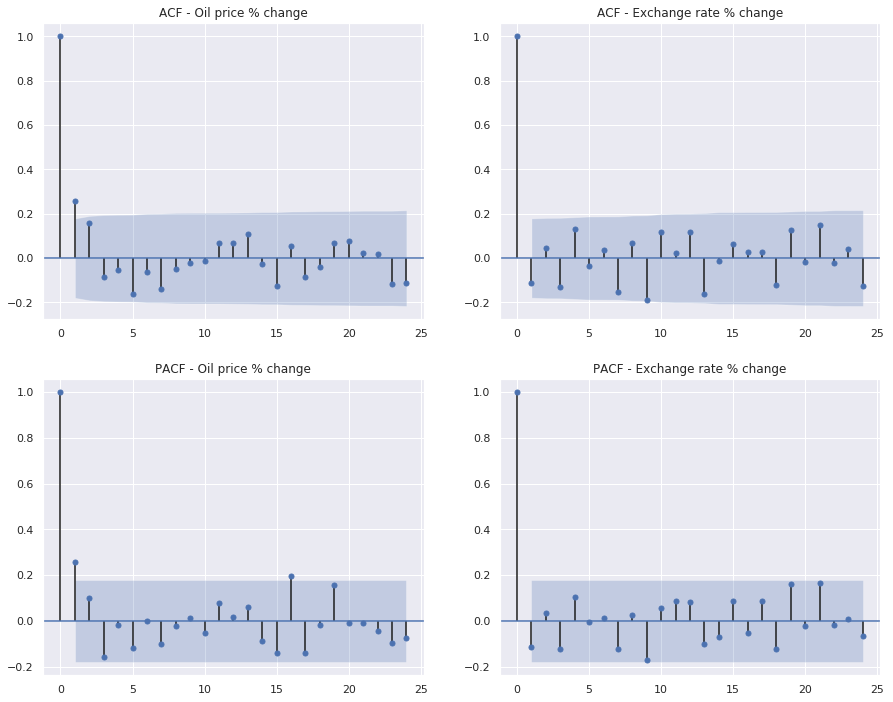

In [18]:
# Plot the acf & pacf functions
fig, ax = plt.subplots(2, 2, figsize=(15, 12))
plot_acf(combined_mth.DCOILWTICO_pct_change, title='ACF - Oil price % change', lags=24, ax=ax[0, 0])
plot_acf(combined_mth.DEXUSCA_pct_change, title='ACF - Exchange rate % change', lags=24, ax=ax[0, 1])
plot_pacf(combined_mth.DCOILWTICO_pct_change, title='PACF - Oil price % change', lags=24, ax=ax[1, 0])
plot_pacf(combined_mth.DEXUSCA_pct_change, title='PACF - Exchange rate % change', lags=24, ax=ax[1, 1])
plt.show()

The oil price % changes show a significant autocorrelation at lag 1 while exchange rate % changes do not show any significant autocorrelation

## Augmented Dickey-Fuller Test

A random walk is a non-stationary series. The ADF test helps to verify if a series is stationary or non-stationary

In [19]:
# Function to apply the augmented dickey-fuller test on a series and print the results
def random_walk_test(series, series_name):
  adf = adfuller(series)
  if adf[1] <= 0.05:
    result = 'H0 can be rejected (H1 is true).'
  else:
    result = 'H0 cannot be rejected (cannot conclude H0 is false).' 
  print('H0             : {0} is a random walk'.format(series_name.capitalize()))
  print('H1             : {0} is not a random walk'.format(series_name.capitalize()))
  print('Test statistic :', adf[0])
  print('P-value        :', adf[1])
  print('Result         :', result)

In [20]:
# Does the oil price follow a random walk?
random_walk_test(combined_mth.DCOILWTICO, 'oil price')

H0             : Oil price is a random walk
H1             : Oil price is not a random walk
Test statistic : -1.8883126908970216
P-value        : 0.3375790062134464
Result         : H0 cannot be rejected (cannot conclude H0 is false).


In [21]:
# Does the exchange rate follow a random walk?
random_walk_test(combined_mth.DEXUSCA, 'exchange rate')

H0             : Exchange rate is a random walk
H1             : Exchange rate is not a random walk
Test statistic : -0.848065133447348
P-value        : 0.8045941622847899
Result         : H0 cannot be rejected (cannot conclude H0 is false).


In [22]:
# Does the oil price % change follow a random walk?
random_walk_test(combined_mth.DCOILWTICO_pct_change, 'oil price % change')

H0             : Oil price % change is a random walk
H1             : Oil price % change is not a random walk
Test statistic : -6.779426723926632
P-value        : 2.5215672244249146e-09
Result         : H0 can be rejected (H1 is true).


In [23]:
# Does the oil price % change follow a random walk?
random_walk_test(combined_mth.DEXUSCA_pct_change, 'exchange rate % change')

H0             : Exchange rate % change is a random walk
H1             : Exchange rate % change is not a random walk
Test statistic : -7.766658136271757
P-value        : 9.14978894173786e-12
Result         : H0 can be rejected (H1 is true).


Calculating the percentage change on the original series turns them into stationary series while the original series are non-stationary

## Autoregressive Model (AR)

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


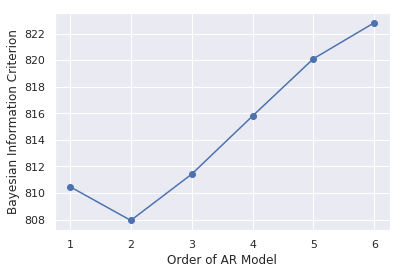

In [24]:
# Fit the oil price data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(combined_mth.DCOILWTICO, order=(p,0))
    res = mod.fit()
    # Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [25]:
# Fit an AR(2) model to the oil price monthly data
model = ARMA(combined_mth.DCOILWTICO, order=(2,0)) # 2 lags is the optimal order (found in the previous cell)
result = model.fit()

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


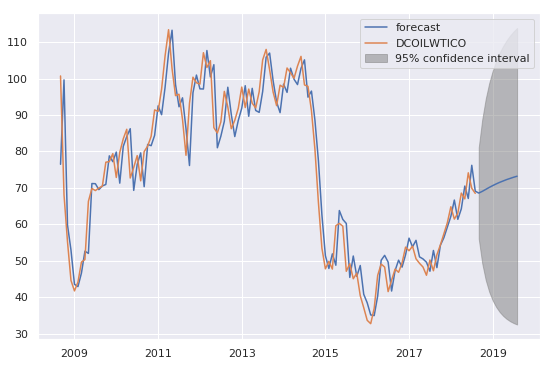

In [26]:
# Forecast the AR(2) model
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
start = combined_mth.index.min().strftime('%Y-%m-%d')
end = (combined_mth.index.max() + relativedelta(years=1)).strftime('%Y-%m-%d')
result.plot_predict(start=start, end=end, ax=ax)
plt.show()

The AR(2) model matches closely the historical data but the forecast is not very precise by looking the at the wide 95 % confidence interval

## Moving Average Model (MA)

In [27]:
# Fit an MA(1) model to the oil price monthly data
model = ARMA(combined_mth.DCOILWTICO, order=(0,1)) # Order 1 model
result = model.fit()

/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/usr/local/envs/py3env/lib/python3.5/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


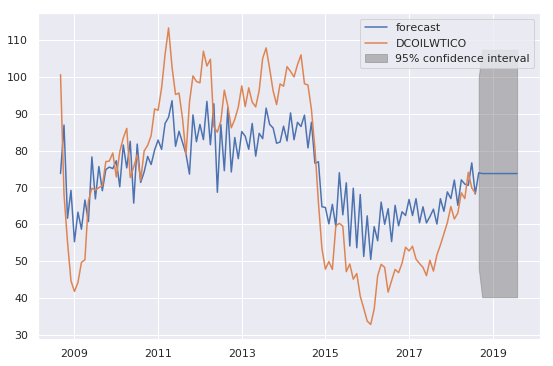

In [28]:
# Forecast the MA(1) model
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
start = combined_mth.index.min().strftime('%Y-%m-%d')
end = (combined_mth.index.max() + relativedelta(years=1)).strftime('%Y-%m-%d')
result.plot_predict(start=start, end=end, ax=ax)
plt.show()

The MA(1) model does not match closely the historical data and the forecast is not very precise by looking the at the wide 95 % confidence interval

## Cointegration

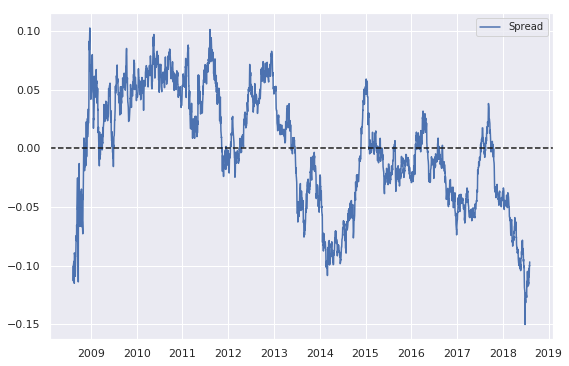

In [37]:
inter = regression.params[0] # Intercept from simple regression of exchange rate on oil price
coeff = regression.params[1] # Slope from simple regression of exchange rate on oil price

# Plot the spread of the two series
plt.figure(figsize=(9, 6))
plt.plot(combined.DEXUSCA - (inter+coeff*combined.DCOILWTICO), label='Spread')
plt.legend(loc='best', fontsize='small')
plt.axhline(y=0, linestyle='--', color='k')
plt.show()

In [38]:
# Does the cointegrated series follow a random walk?
random_walk_test(combined.DEXUSCA - (inter+coeff*combined.DCOILWTICO), 'cointegrated exchange rate & oil price')

H0             : Cointegrated exchange rate & oil price is a random walk
H1             : Cointegrated exchange rate & oil price is not a random walk
Test statistic : -2.68084220361764
P-value        : 0.07741247853099516
Result         : H0 cannot be rejected (cannot conclude H0 is false).


The two series do not seem to be cointegrated